# Finetune Models Genesis

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import unet3d
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import nrrd
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

## Hyperparamters

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

NUM_CLASSES = 11
ROI_NAMES = ['Duodenum',
            'Gallbladder',
            'Kidney L',
            'Kidney R',
            'Large Bowel',
            'Liver',
            'Pancreas',
            'Small Bowel',
            'Spinal Cord',
            'Spleen',
            'Stomach']
HEIGHT = 160
WIDTH = 160
DEPTH = 64

LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
BATCH_SIZE = 1
NUM_EPOCHS = 30
SAVE_N = 5
NUM_WORKERS = 2
PIN_MEMORY = True


cuda:0


## Dataset for In-House Abdomen Dataset

In [3]:
class PrivateAbdomenDataset(Dataset):
    
    def __init__(self, root, eid_file, transform=None):
        self.root = root
        self.filenames = []
        eids = pd.read_csv(eid_file)['eid'].values
        # eids = pd.read_csv(eid_file)['eid'].values[:2]
        for eid in eids:
            for f in os.listdir(os.path.join(root, str(eid))):
                self.filenames.append(f)
        self.transform = transform
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        filename = self.filenames[idx]
        eid = filename.split('_')[0]
        img_lbl = np.load(os.path.join(self.root, eid, filename), allow_pickle=True).item()
        img = torch.from_numpy(img_lbl['image'])
        lbl = torch.from_numpy(img_lbl['label']).type(torch.float32)
        return img, lbl, filename

class InferenceDataset(Dataset):

    def __init__(self, root, eid):
        self.root = root
        self.filenames = []
        for f in os.listdir(os.path.join(root, str(eid))):
            self.filenames.append(f)

    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        filename = self.filenames[idx]
        eid = filename.split('_')[0]
        img_lbl = np.load(os.path.join(self.root, eid, filename), allow_pickle=True).item()
        img = torch.from_numpy(img_lbl['image'])
        lbl = torch.from_numpy(img_lbl['label']).type(torch.float32)
        return img, lbl, filename
    


## Dice Loss Function

In [4]:
def dice_loss(pred, target):
    
    N, C = pred.shape
    losses = []
    alpha = 0.5
    beta  = 0.5

    for i in range(C):
        p0 = (pred[:, i]).float()
        p1 = 1 - p0
        g0 = target[:, i]
        g1 = 1 - target[:, i]

        num = torch.sum(p0 * g0)
        den = num + alpha * torch.sum(p0 * g1) + beta * torch.sum(p1 * g0)
        
        loss = 1 - num / (den + 1e-5)
        if g0.sum() == 0:
            loss = loss * 0

        losses.append(loss)

    return losses

def loss_func(pred, target):
    
    pred = pred.permute(0, 2, 3, 4, 1).contiguous().view(-1, NUM_CLASSES)
    target = target.permute(0, 2, 3, 4, 1).contiguous().view(-1, NUM_CLASSES)
    return dice_loss(pred, target)

## Training and Validation Loop

In [5]:
def train(model, train_loader, optimizer, loss_func):
    
    model.train()
    loop = tqdm(train_loader)

    roi_losses = np.zeros(NUM_CLASSES)
    total_loss = 0

    for img, lbl, filename in loop:
        img = img.to(DEVICE)
        lbl = lbl.to(DEVICE)

        optimizer.zero_grad()
        pred = model(img)
        losses = loss_func(pred, lbl)

        loss = 0
        for i, l in enumerate(losses):
            loss += l
            roi_losses[i] += l.item()

        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())
    
    avg_roi_losses = roi_losses / len(train_loader)
    # print('TRAIN ROI DICE SCORES')
    # for i, roi in enumerate(ROI_NAMES):
    #     print('{}: {:.4}'.format(roi, 1 - avg_roi_losses[i]))

    avg_loss = total_loss / len(train_loader)
    print('AVG TRAIN LOSS: {:.4}'.format(avg_loss))
    return avg_loss, avg_roi_losses

In [6]:
def eval(model, val_loader, loss_func):
    
    model.eval()
    loop = tqdm(val_loader)

    roi_losses = np.zeros(NUM_CLASSES)
    total_loss = 0

    with torch.no_grad():
        for img, lbl, filename in loop:
            img = img.to(DEVICE)
            lbl = lbl.to(DEVICE)

            pred = model(img)
            losses = loss_func(pred, lbl)
            loss = 0
            for i, l in enumerate(losses):
                loss += l
                roi_losses[i] += l.item()

            total_loss += loss.item()

            loop.set_postfix(loss=loss.item())
    
    avg_roi_losses = roi_losses / len(val_loader)
    # print('VAL ROI DICE SCORES')
    # for i, roi in enumerate(ROI_NAMES):
    #     print('{}: {:.4}'.format(roi, 1 - avg_roi_losses[i]))

    avg_loss = total_loss / len(val_loader)
    print('AVG VAL LOSS: {:.4}'.format(avg_loss))
    return avg_loss, avg_roi_losses

## Get Data

In [7]:
root = '/media/hdd10tb/junayedn/private_abdomen/3d_preprocessed'

train_eid_file = '/home/junayedn/ModelsGenesis/pytorch/split/abdomen_train_superpixel_10.csv'
train_data = PrivateAbdomenDataset(root, train_eid_file)
val_eid_file = '/home/junayedn/ModelsGenesis/pytorch/split/abdomen_val.csv'
val_data = PrivateAbdomenDataset(root, val_eid_file)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

## Load Pretrained Models Genesis

In [8]:
model = unet3d.UNet3D(n_class=NUM_CLASSES)

#Load pre-trained weights
weight_dir = './Genesis_Chest_CT.pt'
checkpoint = torch.load(weight_dir)
state_dict = checkpoint['state_dict']
unParalled_state_dict = {}
for key in state_dict.keys():
    unParalled_state_dict[key.replace("module.", "")] = state_dict[key]
unParalled_state_dict.pop('out_tr.final_conv.weight')
unParalled_state_dict.pop('out_tr.final_conv.bias')
new_state_dict = model.state_dict()
new_state_dict.update(unParalled_state_dict)
model.load_state_dict(new_state_dict)

model.to(DEVICE)

UNet3D(
  (down_tr64): DownTransition(
    (ops): Sequential(
      (0): LUConv(
        (conv1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (bn1): ContBatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU(inplace=True)
      )
      (1): LUConv(
        (conv1): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (bn1): ContBatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU(inplace=True)
      )
    )
    (maxpool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_tr128): DownTransition(
    (ops): Sequential(
      (0): LUConv(
        (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (bn1): ContBatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU(inplace=True)
      )
      (

## Finetune Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)


train_loss_history = []
val_loss_history = []

train_roi_loss_history = []
val_roi_loss_history = []

best_val_loss = 10000

for epoch in range(1, NUM_EPOCHS+1):
    print('EPOCH: {}/{}'.format(epoch, NUM_EPOCHS))
    train_loss, train_roi_loss = train(model, train_loader, optimizer, loss_func)
    train_loss_history.append(train_loss)
    train_roi_loss_history.append(train_roi_loss)

    if epoch % SAVE_N == 0:
        val_loss, val_roi_loss = eval(model, val_loader, loss_func)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), '/media/hdd10tb/junayedn/private_abdomen/finetuned_models_genesis/{}_{}_{}.pt'.format(HEIGHT, WIDTH, DEPTH))
  
        val_loss_history.append(val_loss)
        val_roi_loss_history.append(val_roi_loss)

np.save('/media/hdd10tb/junayedn/private_abdomen/finetuned_models_genesis/training_history_{}_{}_{}.npy'.format(HEIGHT, WIDTH, DEPTH),
        {'train_loss_history':train_loss_history,
        'val_loss_history':val_loss_history,
        'train_roi_loss_history':train_roi_loss_history,
        'val_roi_loss_history':val_roi_loss_history})    

## Learning Curves

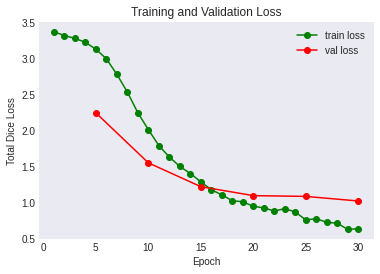

In [11]:
history = np.load('/media/hdd10tb/junayedn/private_abdomen/finetuned_models_genesis/training_history_{}_{}_{}.npy'.format(HEIGHT, WIDTH, DEPTH), allow_pickle=True).item()
train_loss_history = history['train_loss_history']
val_loss_history = history['val_loss_history']
plt.plot(list(range(1,NUM_EPOCHS+1)), train_loss_history, '-go', label='train loss')
plt.plot([epoch for epoch in list(range(1,NUM_EPOCHS+1)) if epoch%SAVE_N==0], val_loss_history, '-ro', label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Total Dice Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [12]:
val_loss_history

[2.2417433871672703,
 1.5474956429921665,
 1.2164350023636452,
 1.0920663269666524,
 1.0812814907385753,
 1.0175560183249988]

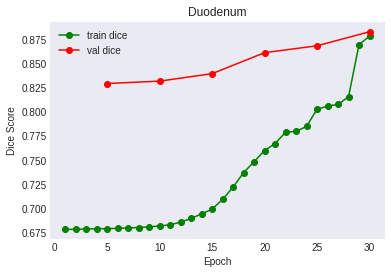

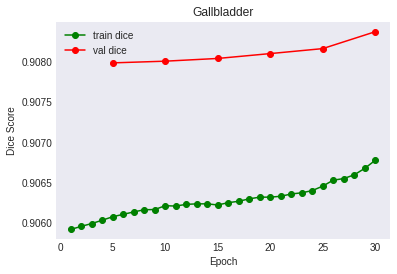

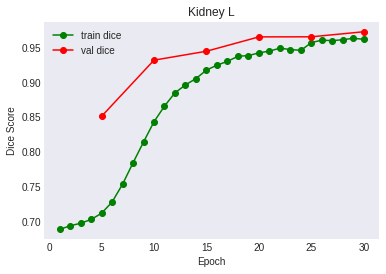

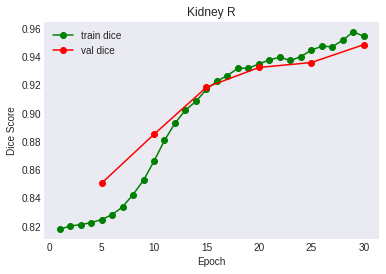

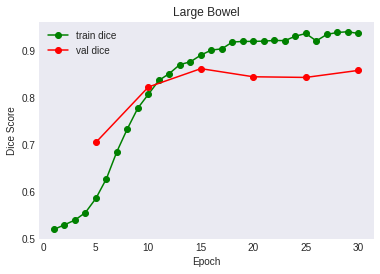

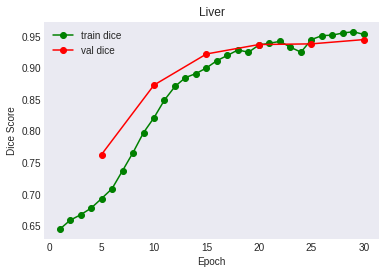

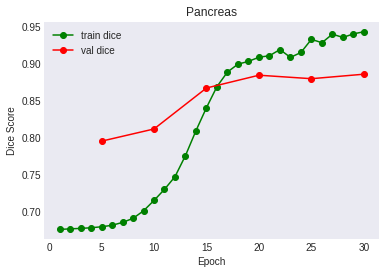

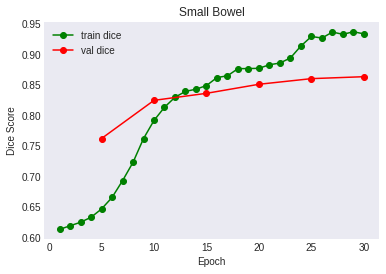

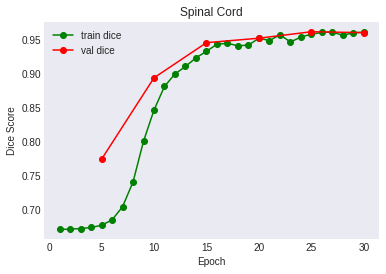

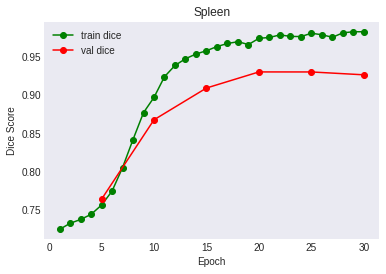

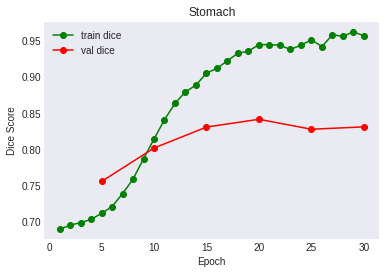

In [13]:
train_roi_loss_history = history['train_roi_loss_history']
val_roi_loss_history = history['val_roi_loss_history']
for i, roi in enumerate(ROI_NAMES):
    roi_train_dice = [1-f[i] for f in train_roi_loss_history]
    roi_val_dice = [1-f[i] for f in val_roi_loss_history]
    plt.plot(list(range(1,NUM_EPOCHS+1)), roi_train_dice, '-go', label='train dice')
    plt.plot([epoch for epoch in list(range(1,NUM_EPOCHS+1)) if epoch%SAVE_N==0], roi_val_dice, '-ro', label='val dice')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.title(roi)
    plt.legend()
    plt.show()

In [14]:
[1 - x for x in val_roi_loss_history[-1]]

[0.8827101439237595,
 0.9083764479710505,
 0.9725299170384041,
 0.9484605846496729,
 0.8573584347963333,
 0.9447083072020457,
 0.8861450997682718,
 0.8635192637260144,
 0.96085962836559,
 0.9265774545761255,
 0.8311986948435123]

## Inference Results

In [7]:
model = unet3d.UNet3D(n_class=NUM_CLASSES)
model.load_state_dict(torch.load('/media/hdd10tb/junayedn/private_abdomen/finetuned_models_genesis/{}_{}_{}.pt'.format(HEIGHT, WIDTH, DEPTH)))
model = model.to(DEVICE)
model.eval()

UNet3D(
  (down_tr64): DownTransition(
    (ops): Sequential(
      (0): LUConv(
        (conv1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (bn1): ContBatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU(inplace=True)
      )
      (1): LUConv(
        (conv1): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (bn1): ContBatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU(inplace=True)
      )
    )
    (maxpool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_tr128): DownTransition(
    (ops): Sequential(
      (0): LUConv(
        (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (bn1): ContBatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU(inplace=True)
      )
      (

In [9]:
root = '/media/hdd10tb/junayedn/private_abdomen/3d_preprocessed'
test_eid_file = '/home/junayedn/ModelsGenesis/pytorch/split/abdomen_val.csv'
test_eids = pd.read_csv(os.path.join(root, test_eid_file))['eid'].values

for idx, eid in enumerate(test_eids):
    print('{}/{}: {}'.format(idx, len(test_eids), eid))
    test_data = InferenceDataset(root, eid)
    test_loader = DataLoader(test_data, batch_size=1, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

    image, _ = nrrd.read('/media/hdd10tb/xiangyiy/data/preprocessed/{}_clean.nrrd'.format(eid))
    image = image.transpose(1,2,0)
    h, w, d = image.shape

    re_pred = np.zeros((11,h,w,d))
    re_lbl = np.zeros((11,h,w,d))
    
    loop = tqdm(test_loader)
    with torch.no_grad():
        for img, lbl, f in loop:
            filename = f[0]
            start_x = int(filename.split('_')[1])
            end_x = start_x + HEIGHT
            start_y = int(filename.split('_')[2])
            end_y = start_y + WIDTH
            start_z = int(filename.split('_')[3].split('.')[0])
            end_z = start_z + DEPTH

            img = img.to(DEVICE)
            lbl = lbl.to(DEVICE)
            pred = model(img)

            lbl = lbl.squeeze().detach().cpu().numpy()
            pred = pred.squeeze().detach().cpu().numpy()
            pred[pred > 0.5] = 1
            pred[pred <= 0.5] = 0
            
            re_pred[:, start_x:end_x, start_y:end_y, start_z:end_z] += pred
            re_lbl[:, start_x:end_x, start_y:end_y, start_z:end_z] += lbl
    
    re_pred[re_pred > 1] = 1
    re_lbl[re_lbl > 1] = 1
    path = '/media/hdd10tb/junayedn/private_abdomen/prediction{}_{}_{}'.format(HEIGHT, WIDTH, DEPTH)
    if not os.path.exists(path):
        os.makedirs(path)
    np.save(os.path.join(path, eid), {'prediction':re_pred, 'label':re_lbl})

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [10]:
def torch_dice_coef_loss(y_true, y_pred, smooth=1.):
    y_true_f = torch.flatten(y_true)
    y_pred_f = torch.flatten(y_pred)
    intersection = torch.sum(y_true_f * y_pred_f)
    return 1. - ((2. * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth))

In [14]:
pred_dir = '/media/hdd10tb/junayedn/private_abdomen/prediction{}_{}_{}'.format(HEIGHT, WIDTH, DEPTH)
mean_roi_dice = np.zeros(NUM_CLASSES)

loop = tqdm(os.listdir(pred_dir))
for f in loop:
    pred_lbl = np.load(os.path.join(pred_dir, f), allow_pickle=True).item()
    pred = pred_lbl['prediction']
    lbl = pred_lbl['label']
    
    for i in range(NUM_CLASSES):
        dice = 1 - torch_dice_coef_loss(torch.from_numpy(lbl[i,:,:,:]), torch.from_numpy(pred[i,:,:,:])).item()
        mean_roi_dice[i] += dice
mean_roi_dice /= len(loop)

print('TEST MEAN DICE SCORES')
for i, roi in enumerate(ROI_NAMES):
    print('{}: {:.4}'.format(roi, mean_roi_dice[i]))

  0%|          | 0/10 [00:00<?, ?it/s]

Duodenum: 0.3783
Gallbladder: 0.00381
Kidney L: 0.8096
Kidney R: 0.5995
Large Bowel: 0.6544
Liver: 0.797
Pancreas: 0.5448
Small Bowel: 0.5592
Spinal Cord: 0.8792
Spleen: 0.8272
Stomach: 0.4502


(285, 457, 211)


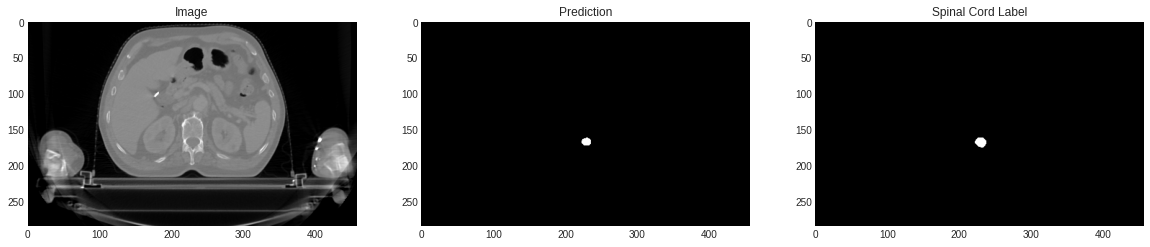

In [15]:
img, _ = nrrd.read('/media/hdd10tb/xiangyiy/data/preprocessed/PA021_clean.nrrd')
img = img.transpose(1,2,0)

maximum = 1000
minimum = -1000
img[img > maximum] = maximum
img[img < minimum] = minimum
img = (img - minimum) / max(1, (maximum - minimum))

pred_lbl = np.load(os.path.join(pred_dir, 'PA021.npy'), allow_pickle=True).item()
pred = pred_lbl['prediction']
lbl = pred_lbl['label']

roi_n = 8
# label, _ = nrrd.read('/media/hdd10tb/xiangyiy/data/preprocessed/PA021_{}.nrrd'.format(ROI_NAMES[roi_n]))
# label = label.transpose(1,2,0)

print(img.shape)
slice_n = 50

fig, ax = plt.subplots(1,3, figsize=(20,20))
ax[0].imshow(img[:,:,slice_n], cmap='gray')
ax[0].set_title('Image')

ax[1].imshow(pred[roi_n,:,:,slice_n], cmap='gray')
ax[1].set_title('Prediction')

ax[2].imshow(lbl[roi_n,:,:,slice_n], cmap='gray')
ax[2].set_title('{} Label'.format(ROI_NAMES[roi_n]))
plt.show()